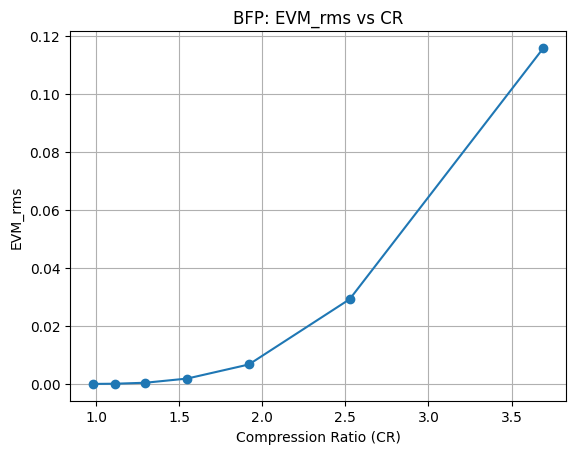

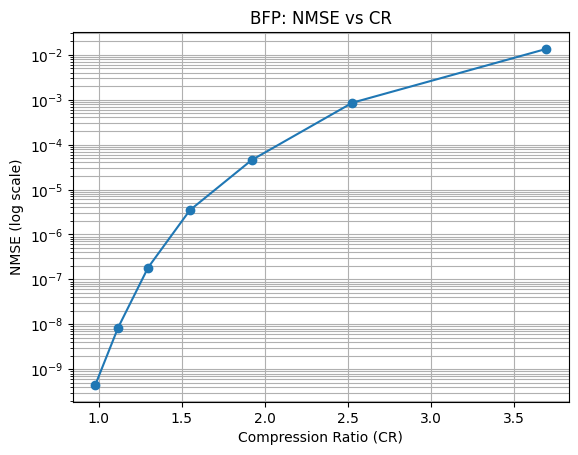

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TX_PRE = "tx/pre-comp.bin"   # 你唯一的参考
RX_DIR = "bfp"  # 里面有 wiqout6/ wiqout8/ ... 或者别的结构

WIQIN = 16
BLOCK_LEN = 12
UD_BITS_PER_BLOCK = 8

wiqout_list = [16, 14, 12, 10, 8, 6, 4]  # 按你的实验点改

def bfp_cr(wiqin: int, wiqout: int, block_len: int = 12, ud_bits: int = 8) -> float:
    raw_bits = 2 * wiqin * block_len
    comp_bits = 2 * wiqout * block_len + ud_bits
    return raw_bits / comp_bits

def read_c64(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    x = np.fromfile(path, dtype=np.complex64)
    if x.size == 0:
        raise RuntimeError(f"Empty file: {path}")
    return x

def evm_nmse_ref(x_ref: np.ndarray, y: np.ndarray):
    n = min(len(x_ref), len(y))
    x = x_ref[:n]
    y = y[:n]
    e = y - x
    nmse = float(np.mean(np.abs(e)**2) / np.mean(np.abs(x)**2))
    evm_rms = float(np.sqrt(nmse))
    return evm_rms, nmse, n

def post_path_of(wiqout: int) -> str:
    return f"{RX_DIR}/rx_wiqout{wiqout}.bin"

x_ref = read_c64(TX_PRE)

rows = []
for wiqout in wiqout_list:
    post_path = post_path_of(wiqout)
    y = read_c64(post_path)

    evm_rms, nmse, n = evm_nmse_ref(x_ref, y)
    cr = bfp_cr(WIQIN, wiqout, BLOCK_LEN, UD_BITS_PER_BLOCK)

    rows.append({
        "WIQOUT": wiqout,
        "CR": cr,
        "EVM_rms": evm_rms,
        "NMSE": nmse,
        "n_samples_compared": n,
        "post_path": post_path
    })

df = pd.DataFrame(rows).sort_values("CR")
df

plt.figure()
plt.plot(df["CR"], df["EVM_rms"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("EVM_rms")
plt.grid(True)
plt.title("BFP: EVM_rms vs CR")
plt.show()

plt.figure()
plt.semilogy(df["CR"], df["NMSE"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("NMSE (log scale)")
plt.grid(True, which="both")
plt.title("BFP: NMSE vs CR")
plt.show()


file size (bytes): 1544228
as float32:
  num samples: 386057
  min / max : 0.0025024372 98.381195
  first 10  : [98.17295  98.130295 98.16983  98.17309  98.12343  98.043144 98.20948
 98.10503  98.14738  98.187744]

as float64:
  num samples: 193028
  min / max : 8.271694114510063e-24 45656987502299.734
  first 10  : [4.45535165e+13 4.47417233e+13 4.41702242e+13 4.44423842e+13
 4.48061813e+13 4.43485660e+13 4.38011925e+13 4.37578738e+13
 4.39294376e+13 4.36669412e+13]
Raw EVM statistics:
  mean : 3.469167813706722
  std  : 7.534234610138597
  min  : 0.0025024372152984142
  max  : 98.38119506835938

After removing top 5% EVM samples:
  threshold (95th percentile): 4.763314628601076
  kept ratio : 0.9499996114563394
  mean       : 2.734946596356178
  std        : 0.89053284501571
  min        : 0.0025024372152984142
  max        : 4.7632856369018555


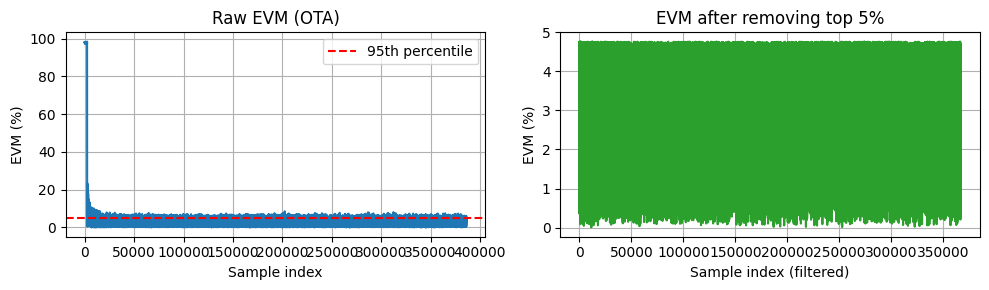

In [42]:
import os
import numpy as np

path = "evm/evm.bin"

print("file size (bytes):", os.path.getsize(path))

# 先假设是 float32
x32 = np.fromfile(path, dtype=np.float32)
print("as float32:")
print("  num samples:", x32.size)
print("  min / max :", x32.min(), x32.max())
print("  first 10  :", x32[:10])

# 再试试 float64（防止你 File Sink 设成了 double）
x64 = np.fromfile(path, dtype=np.float64)
print("\nas float64:")
print("  num samples:", x64.size)
print("  min / max :", x64.min(), x64.max())
print("  first 10  :", x64[:10])

import matplotlib.pyplot as plt

evm = x32.astype(float)

# ---------- 原始统计 ----------
print("Raw EVM statistics:")
print("  mean :", evm.mean())
print("  std  :", evm.std())
print("  min  :", evm.min())
print("  max  :", evm.max())

# ---------- 去掉前 5%（最大的 5%） ----------
p95 = np.percentile(evm, 95)
mask = evm <= p95
evm_trim = evm[mask]

print("\nAfter removing top 5% EVM samples:")
print("  threshold (95th percentile):", p95)
print("  kept ratio :", evm_trim.size / evm.size)
print("  mean       :", evm_trim.mean())
print("  std        :", evm_trim.std())
print("  min        :", evm_trim.min())
print("  max        :", evm_trim.max())

# ---------- 可视化 ----------
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(evm, color="tab:blue")
plt.axhline(p95, color="r", linestyle="--", label="95th percentile")
plt.title("Raw EVM (OTA)")
plt.xlabel("Sample index")
plt.ylabel("EVM (%)")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(evm_trim, color="tab:green")
plt.title("EVM after removing top 5%")
plt.xlabel("Sample index (filtered)")
plt.ylabel("EVM (%)")
plt.grid(True)

plt.tight_layout()
plt.show()



file size (bytes): 8182376
as float32:
  num samples: 2045594
  min / max : 0.044415534 99.83604
  first 10  : [99.780785 99.777725 99.78295  99.78081  99.79845  99.787506 99.78743
 99.782295 99.78548  99.7862  ]

as float64:
  num samples: 1022797
  min / max : 6.94592942393437e-10 51868617510690.266
  first 10  : [5.17989921e+13 5.18125481e+13 5.18420088e+13 5.18190912e+13
 5.18362710e+13 5.18127829e+13 5.17980525e+13 5.17955695e+13
 5.17929523e+13 5.17877178e+13]
Raw EVM statistics:
  mean : 69.79198392022954
  std  : 29.74199766938707
  min  : 0.04441553354263306
  max  : 99.8360366821289

After removing top 5% EVM samples:
  threshold (95th percentile): 99.69426727294922
  kept ratio : 0.9500169632879252
  mean       : 68.2183474436959
  std        : 29.69147237913926
  min        : 0.04441553354263306
  max        : 99.69426727294922


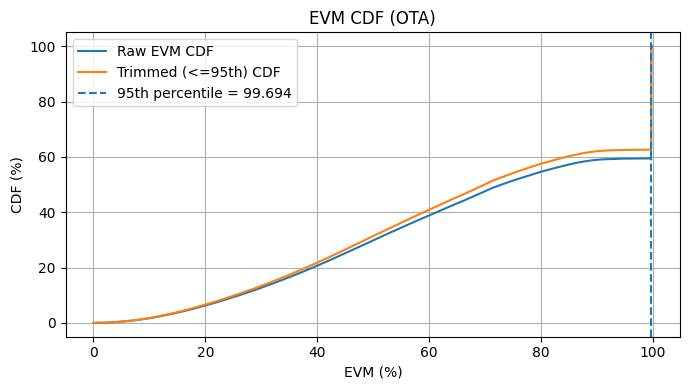

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = "evm/evm_1bit.bin"
print("file size (bytes):", os.path.getsize(path))

# 先假设是 float32
x32 = np.fromfile(path, dtype=np.float32)
print("as float32:")
print("  num samples:", x32.size)
print("  min / max :", x32.min(), x32.max())
print("  first 10  :", x32[:10])

# 再试试 float64（防止 File Sink 设成了 double）
x64 = np.fromfile(path, dtype=np.float64)
print("\nas float64:")
print("  num samples:", x64.size)
print("  min / max :", x64.min(), x64.max())
print("  first 10  :", x64[:10])

evm = x32.astype(float)

# ---------- 原始统计 ----------
print("Raw EVM statistics:")
print("  mean :", evm.mean())
print("  std  :", evm.std())
print("  min  :", evm.min())
print("  max  :", evm.max())

# ---------- 去掉前 5%（最大的 5%） ----------
p95 = np.percentile(evm, 95)
evm_trim = evm[evm <= p95]

print("\nAfter removing top 5% EVM samples:")
print("  threshold (95th percentile):", p95)
print("  kept ratio :", evm_trim.size / evm.size)
print("  mean       :", evm_trim.mean())
print("  std        :", evm_trim.std())
print("  min        :", evm_trim.min())
print("  max        :", evm_trim.max())

# ---------- CDF 函数 ----------
def empirical_cdf(data: np.ndarray):
    data = np.asarray(data)
    data = data[np.isfinite(data)]          # 防 NaN/Inf
    data_sorted = np.sort(data)
    cdf = np.arange(1, data_sorted.size + 1) / data_sorted.size
    return data_sorted, cdf

# ---------- 计算 CDF ----------
x_raw, cdf_raw = empirical_cdf(evm)
x_trim, cdf_trim = empirical_cdf(evm_trim)

# ---------- 可视化：CDF ----------
plt.figure(figsize=(7,4))

plt.plot(x_raw, 100*cdf_raw, label="Raw EVM CDF")
plt.plot(x_trim, 100*cdf_trim, label="Trimmed (<=95th) CDF")

# 标出 95th percentile 的位置（在 raw 上）
plt.axvline(p95, linestyle="--", label=f"95th percentile = {p95:.3f}")

plt.title("EVM CDF (OTA)")
plt.xlabel("EVM (%)")
plt.ylabel("CDF (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


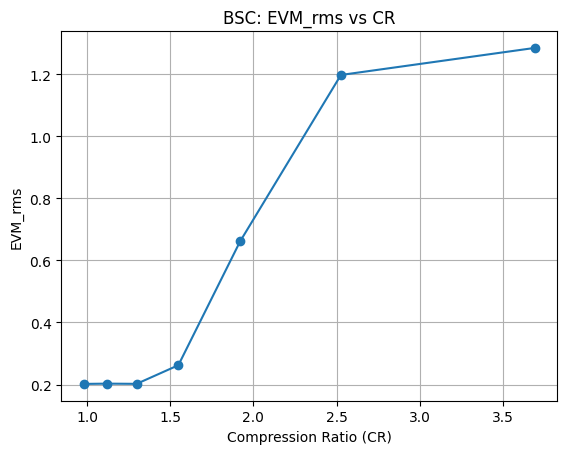

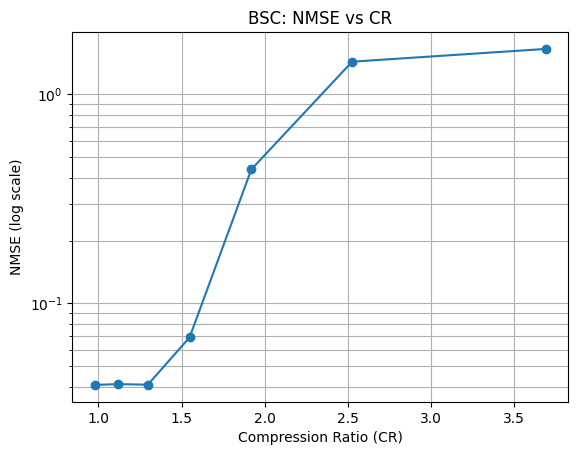

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TX_PRE = "tx/pre-comp.bin"   # 你唯一的参考
RX_DIR = "bsc"               # 改成你的 BSC 输出目录：里面有 rx_wiqout16.bin / rx_wiqout12.bin / ...

WIQIN = 16
BLOCK_LEN = 12
UD_BITS_PER_BLOCK = 8        # BSC: scaler per block stored as 1 byte (8 bits)

wiqout_list = [16, 14, 12, 10, 8, 6, 4]  # 按你的实验点改


def bsc_cr(wiqin: int, wiqout: int, block_len: int = 12, ud_bits: int = 8) -> float:
    """
    BSC/BS compression ratio:
      raw bits per block  = 2*WIQIN*BLOCK_LEN
      comp bits per block = 2*WIQOUT*BLOCK_LEN + ud_bits
    (ud_bits=8 because scaler is 1 byte per block)
    """
    raw_bits = 2 * wiqin * block_len
    comp_bits = 2 * wiqout * block_len + ud_bits
    return raw_bits / comp_bits


def read_c64(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    x = np.fromfile(path, dtype=np.complex64)
    if x.size == 0:
        raise RuntimeError(f"Empty file: {path}")
    return x


def evm_nmse_ref(x_ref: np.ndarray, y: np.ndarray):
    n = min(len(x_ref), len(y))
    x = x_ref[:n]
    y = y[:n]
    e = y - x
    nmse = float(np.mean(np.abs(e)**2) / np.mean(np.abs(x)**2))
    evm_rms = float(np.sqrt(nmse))
    return evm_rms, nmse, n


def post_path_of(wiqout: int) -> str:
    return f"{RX_DIR}/rx_wiqout{wiqout}.bin"


# ===== run =====
x_ref = read_c64(TX_PRE)

rows = []
for wiqout in wiqout_list:
    post_path = post_path_of(wiqout)
    y = read_c64(post_path)

    evm_rms, nmse, n = evm_nmse_ref(x_ref, y)
    cr = bsc_cr(WIQIN, wiqout, BLOCK_LEN, UD_BITS_PER_BLOCK)

    rows.append({
        "WIQOUT": wiqout,
        "CR": cr,
        "EVM_rms": evm_rms,
        "NMSE": nmse,
        "n_samples_compared": n,
        "post_path": post_path
    })

df_bsc = pd.DataFrame(rows).sort_values("CR")
df_bsc

plt.figure()
plt.plot(df_bsc["CR"], df_bsc["EVM_rms"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("EVM_rms")
plt.grid(True)
plt.title("BSC: EVM_rms vs CR")
plt.show()

plt.figure()
plt.semilogy(df_bsc["CR"], df_bsc["NMSE"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("NMSE (log scale)")
plt.grid(True, which="both")
plt.title("BSC: NMSE vs CR")
plt.show()



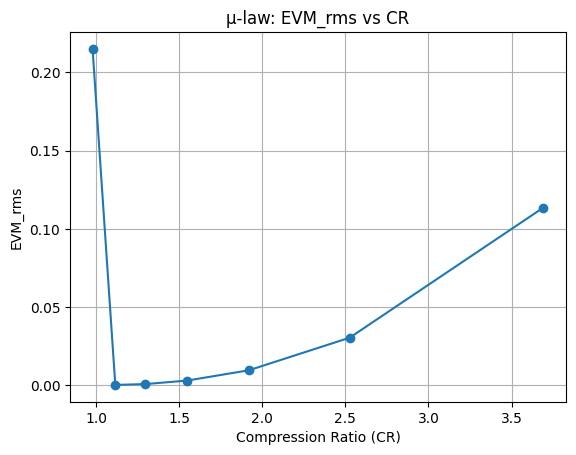

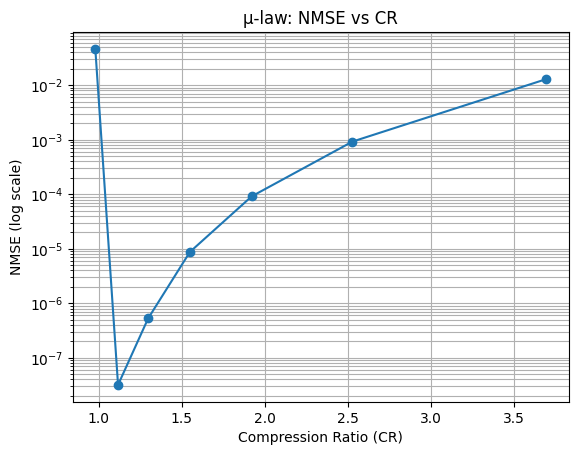

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TX_PRE = "tx/pre-comp.bin"   # 你唯一的参考
RX_DIR = "mulaw"             # 改成你的 µ-law 输出目录：里面有 rx_wiqout16.bin / rx_wiqout12.bin / ...

WIQIN = 16
BLOCK_LEN = 12
UD_BITS_PER_BLOCK = 8        # µ-law: compShift per block stored as 1 byte (8 bits)

wiqout_list = [16, 14, 12, 10, 8, 6, 4]  # 按你的实验点改


def mulaw_cr(wiqin: int, wiqout: int, block_len: int = 12, ud_bits: int = 8) -> float:
    """
    µ-law compression ratio (same payload accounting style as BSC):
      raw bits per block  = 2*WIQIN*BLOCK_LEN
      comp bits per block = 2*WIQOUT*BLOCK_LEN + ud_bits
    (ud_bits=8 because compShift is 1 byte per block)
    """
    raw_bits = 2 * wiqin * block_len
    comp_bits = 2 * wiqout * block_len + ud_bits
    return raw_bits / comp_bits


def read_c64(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    x = np.fromfile(path, dtype=np.complex64)
    if x.size == 0:
        raise RuntimeError(f"Empty file: {path}")
    return x


def evm_nmse_ref(x_ref: np.ndarray, y: np.ndarray):
    n = min(len(x_ref), len(y))
    x = x_ref[:n]
    y = y[:n]
    e = y - x
    nmse = float(np.mean(np.abs(e)**2) / np.mean(np.abs(x)**2))
    evm_rms = float(np.sqrt(nmse))
    return evm_rms, nmse, n


def post_path_of(wiqout: int) -> str:
    return f"{RX_DIR}/rx_wiqout{wiqout}.bin"


# ===== run =====
x_ref = read_c64(TX_PRE)

rows = []
for wiqout in wiqout_list:
    post_path = post_path_of(wiqout)
    y = read_c64(post_path)

    evm_rms, nmse, n = evm_nmse_ref(x_ref, y)
    cr = mulaw_cr(WIQIN, wiqout, BLOCK_LEN, UD_BITS_PER_BLOCK)

    rows.append({
        "WIQOUT": wiqout,
        "CR": cr,
        "EVM_rms": evm_rms,
        "NMSE": nmse,
        "n_samples_compared": n,
        "post_path": post_path
    })

df_mulaw = pd.DataFrame(rows).sort_values("CR")
df_mulaw

plt.figure()
plt.plot(df_mulaw["CR"], df_mulaw["EVM_rms"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("EVM_rms")
plt.grid(True)
plt.title("µ-law: EVM_rms vs CR")
plt.show()

plt.figure()
plt.semilogy(df_mulaw["CR"], df_mulaw["NMSE"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("NMSE (log scale)")
plt.grid(True, which="both")
plt.title("µ-law: NMSE vs CR")
plt.show()


In [39]:
# --- 临时 hack：伪造 Positioner 模块 ---
import types
import sys

Positioner = types.ModuleType("Positioner")

class Position:
    pass

Positioner.Position = Position
sys.modules["Positioner"] = Positioner

# 再 load
import numpy as np
positions = np.load("position.npy", allow_pickle=True)

import numpy as np

# === 修改为你的 positions.npy 路径 ===
positions_path = "position.npy"

# 读取（必须 allow_pickle=True，因为是对象数组）
positions = np.load(positions_path, allow_pickle=True)

print(f"Loaded positions: {len(positions)} samples")
print(f"Type of one element: {type(positions[0])}")

# 查看第一个 position 的可用属性
print("\nAttributes of positions[0]:")
print(dir(positions[0]))

# 打印前 5 个点的坐标（常见字段）
print("\nFirst 5 positions:")
for i, p in enumerate(positions[:5]):
    x = getattr(p, "x", None)
    y = getattr(p, "y", None)
    z = getattr(p, "z", None)
    t = getattr(p, "t", None)
    print(f"[{i}] x={x}, y={y}, z={z}, t={t}")


AttributeError: Can't get attribute 'PositionerValue' on <module 'Positioner'>